In [147]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc
from quantize import * 
from gain_shape_quantize import *
from bitpack import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
codebook = np.array([(2, 0), (-2, 0), (1, 1), (1, -1), (-1, 1), (-1, -1), (0, 2), (0, -2)])
normalized = codebook/np.linalg.norm(codebook, axis=1, keepdims=True)
codebook, normalized

(array([[ 2,  0],
        [-2,  0],
        [ 1,  1],
        [ 1, -1],
        [-1,  1],
        [-1, -1],
        [ 0,  2],
        [ 0, -2]]),
 array([[ 1.        ,  0.        ],
        [-1.        ,  0.        ],
        [ 0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678],
        [-0.70710678,  0.70710678],
        [-0.70710678, -0.70710678],
        [ 0.        ,  1.        ],
        [ 0.        , -1.        ]]))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
DEBUG:matplotlib.animation:frame size in pixels is 576 x 576
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x576', '-pix_fmt', 'rgba', '-r', '10.0', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/mq/x3x5zmh11dq0mb5bd0d3_82r0000gp/T/tmpimilmb7e/temp.m4v']
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplot

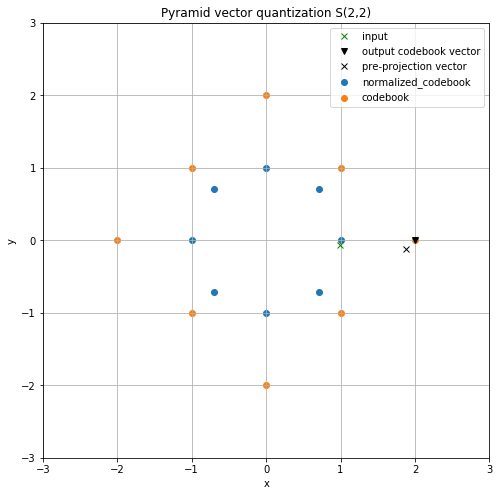

In [614]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Pyramid vector quantization S(2,2)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(( -3, 3))
ax.set_ylim((-3, 3))

line_input, = ax.plot([], [], 'gx', lw=20, label='input')
line_output, = ax.plot([], [], 'kv', lw=20, label='output codebook vector')
line_preproj, = ax.plot([], [], 'kx', lw=20, label='pre-projection vector')
ax.scatter(normalized[:,0], normalized[:,1], label='normalized_codebook')
ax.scatter(codebook[:,0], codebook[:,1], label='codebook')
ax.legend()
ax.grid()

# initialization function: plot the background of each frame
def init():
    line_input.set_data([], [])
    return (line_input,)

# animation function. This is called sequentially
def animate(t):
    pt = np.exp(2*np.pi* 0.01 * 1j * t)
    x = pt.real
    y = pt.imag
    line_input.set_data(x, y)
    act, rounded = pvq_search(np.array([x,y]), 2)
    
    line_output.set_data(rounded[0], rounded[1])
    line_preproj.set_data(act[0], act[1])

    return (line_input,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

HTML(anim.to_html5_video())
plt.savefig('pvq_example.png')

In [7]:
for i in range(2, 20):
    a_g, a_f = gain_shape_alloc(10, i, -2)
    print(f"For N={i}, bits for gain= {a_g}, bits for shape={a_f}")


For N=2, bits for gain= 7, bits for shape=3
For N=3, bits for gain= 6, bits for shape=4
For N=4, bits for gain= 5, bits for shape=5
For N=5, bits for gain= 5, bits for shape=5
For N=6, bits for gain= 4, bits for shape=6
For N=7, bits for gain= 4, bits for shape=6
For N=8, bits for gain= 4, bits for shape=6
For N=9, bits for gain= 4, bits for shape=6
For N=10, bits for gain= 4, bits for shape=6
For N=11, bits for gain= 4, bits for shape=6
For N=12, bits for gain= 4, bits for shape=6
For N=13, bits for gain= 4, bits for shape=6
For N=14, bits for gain= 4, bits for shape=6
For N=15, bits for gain= 4, bits for shape=6
For N=16, bits for gain= 4, bits for shape=6
For N=17, bits for gain= 4, bits for shape=6
For N=18, bits for gain= 4, bits for shape=6
For N=19, bits for gain= 4, bits for shape=6


In [7]:
c = [-1,1]
b = encode_pvq_vector(np.array(c), 2)
print(c)
decoded = decode_pvq_vector(b, len(c), 2)
print(f'in: {c} idx: {b} decoded: {decoded}')

[-1, 1]
in: [-1, 1] idx: 4 decoded: [-1  1]


In [8]:
for c in codebook:
    b = encode_pvq_vector(np.array(c), 2)
    decoded = decode_pvq_vector(b, len(c), 2)
    print(f'in: {c} idx: {b} decoded: {decoded} success: {np.allclose(c, decoded)}')

in: [2 0] idx: 6 decoded: [2 0] success: True
in: [-2  0] idx: 7 decoded: [-2  0] success: True
in: [1 1] idx: 2 decoded: [1 1] success: True
in: [ 1 -1] idx: 3 decoded: [ 1 -1] success: True
in: [-1  1] idx: 4 decoded: [-1  1] success: True
in: [-1 -1] idx: 5 decoded: [-1 -1] success: True
in: [0 2] idx: 0 decoded: [0 2] success: True
in: [ 0 -2] idx: 1 decoded: [ 0 -2] success: True


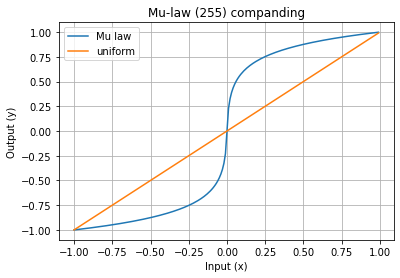

In [613]:
x = np.arange(-1, 1, 0.01)
y = mu_law_fn(x)
x_hat = inv_mu_law_fn(y)
plt.plot(x, y, label='Mu law')
plt.plot(x, x_hat, label='uniform')
plt.grid()
plt.xlabel('Input (x)')
plt.ylabel('Output (y)')
plt.title('Mu-law (255) companding')
plt.legend()
plt.savefig('mulaw.png', dpi=200)

In [13]:
for c in codebook:
    b = encode_pvq_vector(np.array(c), 2, N)
    decoded = decode_pvq_vector(b, len(c), 2, N)
    print(f'in: {c} idx: {b} decoded: {decoded} success: {np.allclose(c, decoded)}')

in: [2 0] idx: 6 decoded: [2 0] success: True
in: [-2  0] idx: 7 decoded: [-2  0] success: True
in: [1 1] idx: 2 decoded: [1 1] success: True
in: [ 1 -1] idx: 3 decoded: [ 1 -1] success: True
in: [-1  1] idx: 4 decoded: [-1  1] success: True
in: [-1 -1] idx: 5 decoded: [-1 -1] success: True
in: [0 2] idx: 0 decoded: [0 2] success: True
in: [ 0 -2] idx: 1 decoded: [ 0 -2] success: True


In [31]:
L = 10
x = np.random.rand(L) * 2 - 1
b = 41
k_fine=-2
gain, shape = quantize_gain_shape(x, len(x), b, k_fine=k_fine)
print(gain, shape)
dequantized = dequantize_gain_shape(gain, shape, b, len(x), k_fine=k_fine)

vq_error = 10*np.log10(np.mean((x-dequantized)**2))

# calculate scalar quantization error
scalar_quant = vDequantizeUniform(vQuantizeUniform(x, int(b//len(x))), int(b//len(x)))
sq_error = 10*np.log10(np.mean((x-scalar_quant)**2))

# Calcualte FP quantization error
x = np.random.rand(10) * 2 - 1
scale_bits = 3
mantissa_bits = int((b - scale_bits)/L)
scale = ScaleFactor(np.max(x), scale_bits, mantissa_bits)
mantissa = vMantissa(x, scale, scale_bits, mantissa_bits)
fp_quant = vDequantize(scale, mantissa, scale_bits, mantissa_bits)
fp_error = 10*np.log10(np.mean((x-fp_quant)**2))

print(f"input: {x}\nvq_decoded:{dequantized} scalar_decoded: {scalar_quant} fp_decoded: {fp_quant}\nvq_err:{vq_error}dB scalar_err: {sq_error}dB fp_err:{fp_error}dB")

bits_gain: 7 bits_shape 34
original gain: 2.096183593794986
k 26 used bits 33.96013838797717
Encoded codebook vector: [ 4 -3  2 -1  4  3  0 -4 -1 -4]
Quantized shape index: 12651263935
46 12651263935
7 34
decoded gain:2.1385522808407327
k 26
Decoded codebook vector: [ 4 -3  2 -1  4  3  0 -4 -1 -4]
input: [ 0.50109109 -0.79484578 -0.50507654 -0.87120909  0.2676444   0.03753963
  0.36513157  0.92884837 -0.78289436 -0.5285729 ]
vq_decoded:[ 0.91188176 -0.68391132  0.45594088 -0.22797044  0.91188176  0.68391132
  0.         -0.91188176 -0.22797044 -0.91188176] scalar_decoded: [ 0.93333333 -0.66666667  0.4        -0.26666667  0.8         0.66666667
  0.         -0.93333333 -0.26666667 -0.93333333] fp_decoded: [ 0.62561095 -0.87585533 -0.62561095 -0.87585533  0.37536657  0.
  0.37536657  0.87585533 -0.87585533 -0.62561095]
vq_err:-26.32956462920552dB scalar_err: -28.07217127920019dB fp_err:-21.511811395114947dB


In [192]:
L = 100
bit_alloc = 32
k_fine = 0
x = np.random.rand(L) * 2 - 1
x = x /np.linalg.norm(x)
mid_idx, side_idx, theta_idx = split_band_encode(x, bit_alloc, k_fine=k_fine)
print(mid_idx, side_idx, theta_idx)
x_hat = split_band_decode(mid_idx, side_idx, theta_idx, bit_alloc, L, k_fine)
error = 10*np.log10(np.mean((x-x_hat)**2))
print(list(zip(x, x_hat)))

expected_snr = 6*bit_alloc/L
print(f'error: {error}dB expected: -{expected_snr}')

theta  0.7334548770156908
bitalloc theta, mid, side 3 18 11
encode theta: 0.7334548770156908
48446 77 2
decoded theta: 0.8975979010256552
bitalloc theta, mid, side 3 7 22
[(-0.14620531852029747, 0.0), (0.017398135984630504, 0.0), (0.06683795527800009, 0.0), (-0.12409827913871756, 0.0), (-0.03420453769318395, 0.0), (-0.0359722098692504, 0.0), (0.04545838864356778, 0.0), (-0.07783692353750894, 0.0), (0.14520670791137497, 0.0), (-0.13576840881287966, 0.0), (0.033823120351757927, 0.0), (-0.1475560813700094, 0.0), (0.01080174151777811, 0.0), (0.17871506625560218, 0.0), (-0.14229804086164172, 0.0), (-0.10004941598370329, 0.0), (0.1578032410990381, 0.0), (0.08140492740251724, 0.0), (-0.17463815578468117, 0.0), (0.04971536779331541, 0.0), (0.02883034541920324, 0.0), (0.0519876478771715, 0.0), (-0.06256131520894305, 0.0), (-0.008765833851467026, 0.0), (-0.06601545289985976, 0.0), (-0.15756236502524018, 0.0), (0.004759169694642481, 0.4408738668949674), (-0.08710145878567173, 0.0), (0.08431483363

In [212]:
bit_allocation_ms(28, 0.8453496720461388, 50, k_fine=0)

in bitallocation ms 28 0.8453496720461388 50


(3, 8, 17)

In [573]:
sys.setrecursionlimit(5000)

In [602]:
# test quantize_gain_shape
L = 50
bit_alloc = 100
k_fine = 0

In [603]:
x = np.random.rand(L) * 2 - 1
# x = np.array([-0.67187128 ,-0.51468582  ,0.11769897  ,0.51945591])

In [604]:
indices, bits  = quantize_gain_shape(x, bit_alloc, k_fine)
print(indices, bits, sum(bits))

# pack bits
pb = PackedBits()
pb.Size(np.ceil(sum(bits)/8).astype(np.int))
for idx, nBits in zip(indices, bits):
    pb.WriteBits(idx, nBits) # encode indices

pb.ResetPointers()  
x_hat = dequantize_gain_shape(pb,
                          bit_alloc,
                          L,
                          k_fine)
error = 10*np.log10(np.mean((x-x_hat)**2))

expected_snr = 6.02*bit_alloc/L
print(list(zip(x, x_hat)))
scale_bits = 3
mantissa_bits = int((bit_alloc-scale_bits)//L)
scale = ScaleFactor(np.max(x), scale_bits, mantissa_bits)
mantissa = vMantissa(x, scale, scale_bits, mantissa_bits)
fp_quant = vDequantize(scale, mantissa, scale_bits, mantissa_bits)
fp_error = 10*np.log10(np.mean((x-fp_quant)**2))

print(f'error: {error}dB expected: -{expected_snr} fp_error: {fp_error}dB {np.linalg.norm(x)} {np.linalg.norm(x_hat)}')

DEBUG:gain_shape_quantize:Original bits_gain: 4 bits_shape 96
DEBUG:gain_shape_quantize:[-1.54439414e-01  2.04597080e-02  8.56109375e-02  1.13387573e-01
  1.22931156e-01  1.99548903e-02  1.18397525e-01  7.92122810e-02
  4.37155326e-02  2.24911200e-01  2.20820543e-04 -2.90008729e-03
 -1.52496932e-01 -3.59847355e-02 -8.33420596e-02 -1.84749325e-01
 -1.35162903e-01  2.34735467e-01 -6.53948421e-02 -1.98150277e-01
  1.93258878e-01  2.19492277e-01 -7.81455244e-03 -1.72717791e-01
  1.18935680e-01  1.36298824e-01  4.61332621e-02 -1.62905520e-01
  1.11145764e-01 -5.52229070e-02  6.44537543e-02  1.46542437e-01
 -7.97003889e-02  8.20683790e-02 -1.67250507e-01  1.83738233e-01
  1.31145702e-01 -2.21189101e-01 -1.52235724e-01  2.29349175e-01
  7.77766936e-02  1.84191073e-01 -1.64521255e-01  3.87599899e-02
  4.90409544e-02  2.05490949e-01  2.23896001e-01 -1.69371533e-02
 -2.35988204e-01 -1.75654955e-01]
DEBUG:gain_shape_quantize:Splitting because bit alloc is 96
DEBUG:gain_shape_quantize:Encoded thet

[16, 8, 4, 38, 93, 3, 334, 21, 10, 5940, 4, 109, 1460, 36] [6, 5, 4, 7, 7, 4, 9, 7, 5, 15, 4, 9, 11, 7] 100
[(-0.651570734914297, -0.3787291642810135), (0.08631829577372074, -0.35348826569094455), (0.3611874720042516, 0.3186520087323511), (0.4783754500537478, 0.6219329368469715), (0.5186392636063646, 0.35348826569094455), (0.08418849946401252, 0.09183279052147666), (0.499512143598704, 1.1059836892013315), (0.3341919195414722, 0.35348826569094455), (0.18443324146594975, 0.3894117994509177), (0.94888702356142, 0.8133853962566154), (0.0009316287839158388, -0.35348826569094455), (-0.012235296410113339, 0.31967272960488397), (-0.6433755177132447, -0.3990071578194425), (-0.1518174665695251, 0.35348826569094455), (-0.351615210800841, -0.3961114010162287), (-0.7794464554382139, -0.7602408040164955), (-0.5702442771558407, -0.35348826569094455), (0.990335023772156, 0.7467520064646258), (-0.27589696370829553, -0.32824736710087554), (-0.8359842752748086, -0.35348826569094455), (0.8153477549268875,

In [601]:
y = x/np.linalg.norm(x)
idx, bits = quantize_pvq(y, bit_alloc)
idx, bits, y

(33165617,
 27,
 array([-0.05490737, -0.19770113,  0.0056235 , -0.09639201, -0.05475662,
         0.02830534,  0.1480228 , -0.07845049, -0.22182928, -0.13124754,
        -0.17488   ,  0.11482395, -0.07838422,  0.0273605 , -0.21426808,
        -0.19359856, -0.16794835, -0.05268356,  0.17757666,  0.20264885,
         0.14029655,  0.01327133,  0.21799943,  0.14926123, -0.2184899 ,
        -0.11439798, -0.11436448, -0.1305215 , -0.02986525,  0.09341637,
        -0.22328037,  0.23345014, -0.12090529, -0.04722506,  0.01762893,
        -0.16570756, -0.08888914, -0.06853803, -0.10848201, -0.0862528 ,
         0.00592263, -0.01004608,  0.19586955, -0.04224446, -0.20662196,
        -0.23172285,  0.17045014,  0.14924239, -0.21389527,  0.08885072]))

In [607]:
pvq_compute_k_for_R(2,3)

(2,
 3,
 array([[1, 0, 0],
        [1, 2, 2],
        [1, 4, 8]]))

In [606]:
pvq_codebook_size(2, 2)

array([[1, 0, 0],
       [1, 2, 2],
       [1, 4, 8]])

In [483]:
y_hat,bits = dequantize_pvq(idx, len(y), bit_alloc)
y_hat, bits

(array([ 0.5220355 ,  0.30602081,  0.5220355 , -0.34202326,  0.09000612,
         0.48603305]),
 34)

In [484]:
error = 10*np.log10(np.mean((y-y_hat)**2))
print(f'error: {error}dB expected:-{bit_alloc*6//len(y)}')

error: -45.84278146271065dB expected:-34


In [554]:
np.tan(0.23407945262041596)

0.23845060133666188

In [550]:
np.log2(0.22)

-2.1844245711374275

In [236]:
indices = [6,0]
bits = [4,0]

In [237]:
pb = PackedBits()
nbytes = sum(bits)//8+1
pb.Size(nbytes)
for idx, nBits in zip(indices, bits):
    pb.WriteBits(idx, nBits) # encode indices
pb.ResetPointers()    

In [238]:
for i in range(nbytes*8):
    print(i,pb.ReadBits(1))

0 0
1 1
2 1
3 0
4 0
5 0
6 0
7 0


In [215]:
pb.GetPackedData()

b'\x80\x00'

In [138]:
R = 2; L = 4;
R / L + 0.5 * np.log2(L) - k_fine

1.5

In [125]:
11//2

5

In [687]:
L = 4
K = 5
N = pvq_codebook_size(L,K)
codebook = []
oops = False
for b in range(N[L][K]):
#     cb = decode_pvq_vector(b, L, K, N)
    cb = decoder(b, L, K, N).step_1()   
    if np.sum(abs(cb)) != K:
        print(b, "l1 norm is not K")
    # Test to see if it's already in there
    for i,cb2 in enumerate(codebook):
        if np.allclose(cb2, cb):
            print("Found duplicate vector", i, b, cb2, cb)
            oops = True
    codebook.append(cb)
    if oops:
        break

print(np.array(codebook))

[[ 0  0  0  5]
 [ 0  0  0 -5]
 [ 0  0  1  4]
 ...
 [-4 -1  0  0]
 [ 5  0  0  0]
 [-5  0  0  0]]


In [678]:
decoder(22, L, K, N).step_1()

12
14
1 2 2
18
2 2 2
22
k 1


array([-1,  1,  1])

In [542]:
N

array([[  1,   0,   0,   0,   0,   0],
       [  1,   2,   2,   2,   2,   2],
       [  1,   4,   8,  12,  16,  20],
       [  1,   6,  18,  38,  66, 102]])

In [266]:
# x = np.array([0.53963551,  0.94695102,  0.19858073, -0.54743883])
x = np.array([-0.68288664, -0.68028159, -0.09013877, -0.16080877])
x /= np.linalg.norm(x)
print(x)
y, pre_search = pvq_search(x, 5)
y, pre_search #, np.round(y), y - np.round(y)

[-0.69584506 -0.69319058 -0.09184924 -0.16386027]
[2. 2. 0. 0.]
Remaining pulses: 1.0


(array([2.11535831, 2.10728872, 0.27922028, 0.4981327 ]),
 array([-2, -2,  0, -1]))

In [730]:
nlines = AssignMDCTLinesFromFreqLimits(1024, 48000)
print(nlines)
# sf_bands = ScaleFactorBands(1024)

[  4.   5.   4.   4.   5.   5.   6.   6.   7.   8.   9.  10.  12.  14.
  16.  19.  24.  30.  38.  47.  56.  76. 107. 149. 363.]
